<a href="https://colab.research.google.com/github/mobarakol/Learning_WhereToLook/blob/master/Learning_Wheretolook_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Where to Look While Tracking Instruments in Robot-assisted Surgery

Directing of the task-specific attention while tracking instrument in surgery holds great potential in robot-assisted intervention. For this purpose, we propose an end-to-end trainable multitask learning (MTL) model for real-time surgical instrument segmentation and attention prediction. Our model is designed with a weight-shared encoder and two task-oriented decoders and optimized for the joint tasks. We introduce batch-Wasserstein (bW) loss and construct a soft attention module to refine the distinctive visual region for efficient saliency learning. For multitask optimization, it is always challenging to obtain convergence of both tasks in the same epoch. We deal with this problem by adopting `poly' loss weight and two phases of training. We further propose a novel way to generate task-aware saliency map and scanpath of the instruments on MICCAI robotic instrument segmentation dataset. Compared to the state of the art segmentation and saliency models, our model outperforms most of the evaluation metrics.

Paper: [Learning Where to Look While Tracking Instruments in Robot-assisted Surgery](https://link.springer.com/chapter/10.1007/978-3-030-32254-0_46) <br>
Code: https://github.com/mobarakol/Learning_WhereToLook<br>

Instrument Classes:"Bipolar Forceps": 1, "Prograsp Forceps": 2, "Large Needle Driver": 3, "Vessel Sealer": 4, "Grasping Retractor": 5, "Monopolar Curve, Scissors": 6, "Other": 7<br>


## Citation
If you use this code for your research, please cite our paper.

```
@inproceedings{islam2019learning,
  title={Learning where to look while tracking instruments in robot-assisted surgery},
  author={Islam, Mobarakol and Li, Yueyuan and Ren, Hongliang},
  booktitle={International Conference on Medical Image Computing and Computer-Assisted Intervention},
  pages={412--420},
  year={2019},
  organization={Springer}
}
```




Download Code, Data and Trained Model

Download Code from Github

In [1]:
!rm -rf Learning_WhereToLook
!git clone https://github.com/mobarakol/Learning_WhereToLook.git
%cd Learning_WhereToLook

Cloning into 'Learning_WhereToLook'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 26 (delta 5), reused 15 (delta 0), pack-reused 0
Unpacking objects: 100% (26/26), done.
/content/Learning_WhereToLook


Download Validation Data and Trained Model

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
ids = ['1YcXNOMZOiqgLUXZf_oCCbyuicVJRNR1J', '1EeEhbgNV9K1Sm9AUst2VeQYiT5TZmVjT']
zip_files = ['instruments17_saliency.zip','epoch_75.pth.tar']
for id, zip_file in zip(ids, zip_files):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(zip_file)
    if zip_file[-3:] == 'zip':
        !unzip -q $zip_file

## Demo

Sample size of test dataset: 441
Mean Avg Dice:0.6579 [Bipolar Forceps:0.4525, Prograsp Forceps:0.6918, Large Needle Driver:0.7985, Vessel Sealer:0.6890]
Saliency Metrics: SIM:0.5254, EMD:0.0085


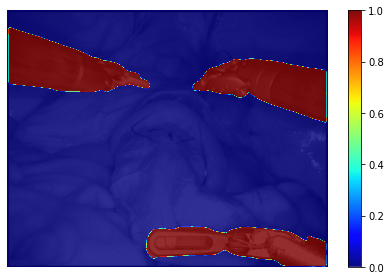

In [10]:
import math
import os
import numpy as np
import argparse
import torch
from torch.utils.data import DataLoader
from model import SalSegNet
from dataset import SurgicalDataset
from utils import seed_everything, calculate_dice, calculate_confusion_matrix_from_arrays
from metrics_functions import AUC_Borji, NSS, SIM
from scipy.stats import wasserstein_distance
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

def plotNNFilterOverlay(input_im, units, interp='bilinear',path='Prob',
                        colormap=cm.jet, isColorbar=True, title='', alpha=0.8):
    plt.clf()
    plt.imshow(input_im, interpolation=interp, cmap='gray')
    plt.imshow(units, interpolation=interp, cmap=colormap, alpha=alpha, vmin=0, vmax=1)
    plt.axis('off')
    if isColorbar:
        plt.colorbar()
    plt.tight_layout()
    prob_path = os.path.join(path,title+'.png')
    plt.savefig(prob_path, bbox_inches='tight', pad_inches=0)


def validate(valid_loader, model, args):
    if not os.path.exists('true'): os.makedirs('true')
    if not os.path.exists('pred'): os.makedirs('pred')
    confusion_matrix = np.zeros(
            (args.num_classes, args.num_classes), dtype=np.uint32)
    model.eval()
    SIM_SCORE, EMD_SCORE = [], []
    with torch.no_grad():
        for batch_idx, (inputs, labels_seg, labels_sal,_) in enumerate(valid_loader):
            inputs, labels_seg = inputs.to(device), np.array(labels_seg)
            pred_seg, output_sal = model(inputs)
            pred_seg = pred_seg.data.max(1)[1].squeeze_(1).cpu().numpy()
            confusion_matrix += calculate_confusion_matrix_from_arrays(
                pred_seg, labels_seg, args.num_classes)
            
            pred_ = output_sal.view(output_sal.size()[0], -1)
            gt_maps_ = labels_sal.view(labels_sal.size()[0], -1)
            labels_sal = np.array(labels_sal.cpu())
            output_sal = np.array(output_sal.cpu())
            for eval_idx in range(0, inputs.size()[0]):
                if(np.max(labels_sal[eval_idx])==0):
                    continue
                SIM_SCORE.append((SIM(labels_sal[eval_idx], np.squeeze(output_sal[eval_idx]))))
                EMD_SCORE.append((wasserstein_distance(pred_[eval_idx].cpu(), gt_maps_[eval_idx].cpu())))
                plotNNFilterOverlay(inputs[eval_idx,0].cpu(),labels_seg[eval_idx], interp='nearest',path='true', title='gt_{}_{}'.format(batch_idx,eval_idx))
                plotNNFilterOverlay(inputs[eval_idx,0].cpu(),pred_seg[eval_idx], interp='bilinear',path='pred', title='pred_{}_{}'.format(batch_idx,eval_idx))   
            
    confusion_matrix = confusion_matrix[1:, 1:]  # exclude background
    dices = {'dice_{}'.format(cls + 1): dice
                for cls, dice in enumerate(calculate_dice(confusion_matrix))}
    dices_per_class = np.array(list(dices.values()))          

    return dices_per_class, SIM_SCORE, EMD_SCORE

def main():
    parser = argparse.ArgumentParser(description='Instrument Segmentation and Saliency')
    parser.add_argument('--num_classes', default=8, type=int, help="num of classes")
    parser.add_argument('--data_root', default='instruments17_saliency', help="data root dir")
    parser.add_argument('--batch_size', default=2, type=int, help="num of classes")
    args = parser.parse_args(args=[])
    dataset_test = SurgicalDataset(data_root=args.data_root, seq_set=[4,7], is_train=False)
    test_loader = DataLoader(dataset=dataset_test, batch_size=args.batch_size, shuffle=False, num_workers=2,
                              drop_last=True)
    
    print('Sample size of test dataset:', dataset_test.__len__())
    model = SalSegNet(num_classes=args.num_classes).to(device)
    model = torch.nn.parallel.DataParallel(model)
    model.load_state_dict(torch.load('epoch_75.pth.tar'))
    dices_per_class, SIM_SCORE, EMD_SCORE = validate(test_loader, model, args)
    print('Mean Avg Dice:%.4f [Bipolar Forceps:%.4f, Prograsp Forceps:%.4f, Large Needle Driver:%.4f, Vessel Sealer:%.4f]'
        %(dices_per_class[:4].mean(),dices_per_class[0], dices_per_class[1],dices_per_class[2],dices_per_class[3]))
    print('Saliency Metrics: SIM:%.4f, EMD:%.4f'%(np.mean(SIM_SCORE), np.mean(EMD_SCORE)))
    
if __name__ == '__main__':
    class_names = ["Bipolar Forceps", "Prograsp Forceps", "Large Needle Driver", "Vessel Sealer", "Grasping Retractor", "Monopolar Curve, Scissors", "Other"]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    seed_everything()
    main()